In [1]:
# !pip install torch
# !pip install torchvision

In [2]:
import os
import xml.etree.ElementTree as ET
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image
from torchvision.ops import nms
from sklearn.metrics import precision_recall_curve, auc
import copy
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [3]:

# set direction and set parameters
data_dir = './Data'
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'xmls')
use_subset = False
sub_percentage = 0.1
train_batch_size = 30
test_batch_size = 1
step_size = 5
gamma = 0.5
lr = 0.003
nms_step_size = 0.1
nms_step = 3
weight_decay= 0.001
num_epochs = 30
nms_iou_thresh = 0.4
mAP_iou_threshold= 0.5
score_thresh_init = 0.0
num_classes = 5
local_model_path = './faster_rcnn_model.pth'
patience = 5
num_worker = os.cpu_count()

In [4]:

# # set direction and set parameters
# data_dir = './Data'
# image_dir = os.path.join(data_dir, 'images')
# label_dir = os.path.join(data_dir, 'xmls')
# use_subset = True
# sub_percentage = 0.1
# train_batch_size = 4
# test_batch_size = 1
# step_size = 20
# gamma = 0.005
# lr = 0.005
# weight_decay= 0.001
# num_epochs = 10
# nms_iou_thresh = 0.01
# mAP_iou_threshold = 0.5
# score_thresh = 0.4
# num_classes = 5
# local_model_path = './faster_rcnn_model.pth'
# patience = 2


In [5]:

# dataset class
class RDD2022Dataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.classes = ['Background', 'D00', 'D10', 'D20', 'D40']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        print(self.class_to_idx)

        self.images = list(sorted(os.listdir(image_dir)))
        self.labels = list(sorted(os.listdir(label_dir)))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # load image and label
        img_path = os.path.join(self.image_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        label_path = os.path.join(self.label_dir, self.labels[idx])
        tree = ET.parse(label_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.iter('object'):
            cls = obj.findtext('name')
            labels.append(self.class_to_idx[cls])
            xmlbox = obj.find('bndbox')
            bbox_coords = ['xmin', 'ymin', 'xmax', 'ymax']
            boxes.append([int(float(xmlbox.findtext(tag))) for tag in bbox_coords])
        # if have label
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # if it doesn't have label
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            area = torch.zeros(0, dtype=torch.float32)

        image_id = torch.tensor([idx])
        iscrowd = torch.zeros(len(boxes), dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target


In [6]:

def get_transform():
    def transform(img, target):
        img = F.to_tensor(img)
        return img, target
    return transform

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Create dataset and data loader
train_dataset = RDD2022Dataset(
    os.path.join(image_dir, 'train'),
    os.path.join(label_dir, 'train'),
    transforms=get_transform()
)

val_dataset = RDD2022Dataset(
    os.path.join(image_dir, 'val'),
    os.path.join(label_dir, 'val'),
    transforms=get_transform()
)

def create_subset(dataset, subset_size):
    # Check subset condition
    if isinstance(subset_size, float) and subset_size > 0 and subset_size < 1:
        subset_size = int(len(dataset) * subset_size)
    elif isinstance(subset_size, int) and subset_size > 0 and subset_size < len(dataset):
        subset_size = subset_size
    else:
        raise ValueError("subset_size must be a positive integer or a float between 0 and 1.")
    # Generate a random subset
    indices = torch.randperm(len(dataset))[:subset_size]
    subset = Subset(dataset, indices)
    return subset

# DataLoader setup
# if using subset
if use_subset:
    train_subset_size = sub_percentage 
    val_subset_size = sub_percentage
    train_subset = create_subset(train_dataset, train_subset_size)
    val_subset = create_subset(val_dataset, val_subset_size)
    train_loader = DataLoader(train_subset, batch_size=train_batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_subset, batch_size=train_batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    print('Using subset')
# if using full dataset
else:
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    val_loader = DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    print('Using full dataset')

# Clear CUDA cache
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()


{'Background': 0, 'D00': 1, 'D10': 2, 'D20': 3, 'D40': 4}
{'Background': 0, 'D00': 1, 'D10': 2, 'D20': 3, 'D40': 4}
Using full dataset


In [7]:

# calculate Intersection over Union (IoU)
def calculate_iou(gt_box, pred_box):
    xi1 = max(gt_box[0], pred_box[0])
    yi1 = max(gt_box[1], pred_box[1])
    xi2 = min(gt_box[2], pred_box[2])
    yi2 = min(gt_box[3], pred_box[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    union_area = gt_area + pred_area - inter_area
    
    if union_area == 0:
        return 0
    iou = inter_area / union_area
    return iou

# apply Non-Max Suppression (NMS) to filter predictions
def apply_nms(orig_prediction, epoch, iou_thresh=nms_iou_thresh, score_thresh_init=score_thresh_init, nms_step = nms_step, step_size = nms_step_size):
    # if no detections to process
    if orig_prediction['scores'].nelement() == 0:
        return {
            'boxes': torch.empty((0, 4), dtype=torch.float32),
            'scores': torch.empty((0,), dtype=torch.float32),
            'labels': torch.empty((0,), dtype=torch.int64)
        }
    # apply NMS
    boxes = orig_prediction['boxes'].float()
    scores = orig_prediction['scores'].float()
    if epoch//nms_step <= 5:
        score_thresh = score_thresh_init + (epoch//nms_step)*nms_step_size
    else:
        score_thresh = 0.5
    high_score_mask = scores > score_thresh
    boxes = boxes[high_score_mask]
    scores = scores[high_score_mask]
    labels = orig_prediction['labels'][high_score_mask]
    keep = nms(boxes, scores, iou_thresh)
    return {'boxes': boxes[keep], 'scores': scores[keep],'labels': labels[keep]}

# update true positives, false positives, and false negatives for each class
def compute_tp_fp_fn_for_image(epoch_index, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels, num_classes, iou_threshold= mAP_iou_threshold):
    # iterate through each class (ignoring the background class)
    for cls in range(1, num_classes):
        # filter ground truth and predictions for the current class
        gt_idx = np.where(gt_labels == cls)[0]
        pred_idx = np.where(pred_labels == cls)[0]

        if len(gt_idx) == 0 and len(pred_idx) == 0:
            continue
        elif len(gt_idx) == 0:
            epoch_index[cls-1,1] += len(pred_boxes[pred_idx])
            continue
        elif len(pred_idx) == 0:
            epoch_index[cls-1,2] += len(gt_boxes[gt_idx])
            continue

        class_gt_boxes = gt_boxes[gt_idx]
        class_pred_boxes = pred_boxes[pred_idx]
        class_pred_scores = pred_scores[pred_idx]

        # sort predictions by scores in descending order
        sorted_indices = np.argsort(-class_pred_scores)
        class_pred_boxes = class_pred_boxes[sorted_indices]

        # initialize counters for true positives, false positives, and false negatives
        tp = 0
        detected = np.zeros(len(class_gt_boxes), dtype=bool)

        # check each predicted box against all GT boxes of the same class
        for pred_box in class_pred_boxes:
            ious = [calculate_iou(pred_box, gt_box) for gt_box in class_gt_boxes]
            max_iou = max(ious)
            max_gt_idx = np.argmax(ious)

            if max_iou >= iou_threshold and not detected[max_gt_idx]:
                tp += 1
                detected[max_gt_idx] = True

        # update class metrics
        epoch_index[cls-1,0] += tp
        epoch_index[cls-1,1] += (len(class_pred_boxes) - tp)  # All non-TPs are FPs
        epoch_index[cls-1,2] += (len(class_gt_boxes) - np.sum(detected))  # GTs not detected are FNs

    return epoch_index


In [8]:

# evaluate the model and calculate mAP along with precision, recall, and F1 scores
def evaluate_or_test_model(model, data_loader, device, epoch):
    model.eval()
    # total_val_loss = 0
    epoch_index = np.zeros((num_classes-1, 3))
    all_detections = [[] for _ in range(num_classes-1)]
    all_annotations = [[] for _ in range(num_classes-1)]

    with torch.no_grad():
        # for each evaluation batch
        for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            for i, output in enumerate(outputs):
                nms_output = apply_nms(output, epoch)
                pred_boxes = nms_output['boxes'].cpu().numpy()
                pred_labels = nms_output['labels'].cpu().numpy()
                pred_scores = nms_output['scores'].cpu().numpy()
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                gt_labels = targets[i]['labels'].cpu().numpy()
                epoch_index = compute_tp_fp_fn_for_image(epoch_index, gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels, num_classes)

                # Store detections and annotations for mAP calculation
                for label in range(1, num_classes):
                    pred_indices = np.where(pred_labels == label)[0]
                    gt_indices = np.where(gt_labels == label)[0]
                    all_detections[label-1].extend([(box, score) for box, score in zip(pred_boxes[pred_indices], pred_scores[pred_indices])])
                    all_annotations[label-1].extend(gt_boxes[gt_indices])

            # Compute losses
            # if targets:
            #     model.train()
            #     loss_dict = model(images, targets)
            #     losses = sum(loss for loss in loss_dict.values())
            #     total_val_loss += losses.item()
            #     model.eval()

            del images, targets, outputs
            clear_memory()

    # avg_loss = total_val_loss / len(data_loader)

    # calculate mAP for each class
    avg_precisions = []
    for class_detections, class_annotations in zip(all_detections, all_annotations):
        if not class_detections or not class_annotations:
            continue
        # sort detections by decreasing confidence
        sorted_detections = sorted(class_detections, key=lambda x: x[1], reverse=True)
        tp = np.zeros(len(sorted_detections))
        fp = np.zeros(len(sorted_detections))
        matched = np.zeros(len(class_annotations), dtype=bool)  # Tracks which GT boxes have been matched

        for d_idx, (bbox, score) in enumerate(sorted_detections):
            ious = [calculate_iou(bbox, gt_bbox) for gt_bbox in class_annotations]
            best_iou = max(ious) if ious else 0
            best_idx = np.argmax(ious) if ious else -1

            if best_iou >= mAP_iou_threshold:
                if not matched[best_idx]:
                    tp[d_idx] = 1
                    matched[best_idx] = True
                else:
                    fp[d_idx] = 1
            else:
                fp[d_idx] = 1

        # accumulate true positives and false positives for precision-recall calculation
        acc_tp = np.cumsum(tp)
        acc_fp = np.cumsum(fp)
        recall = acc_tp / len(class_annotations) if len(class_annotations) > 0 else np.zeros_like(acc_tp)
        precision = acc_tp / (acc_tp + acc_fp) if (acc_tp + acc_fp).any() else np.zeros_like(acc_tp)

        # calculate area under the precision-recall curve (AUC)
        ap = auc(recall, precision)
        avg_precisions.append(ap)

    # compute the mean of average precisions across all classes
    mAP50 = np.mean(avg_precisions) if avg_precisions else 0

    # calculate overall precision, recall, and F1 score
    tp_total = epoch_index[:, 0]
    fp_total = epoch_index[:, 1]
    fn_total = epoch_index[:, 2]
    recall = tp_total / (tp_total + fn_total + 1e-6)
    precision = tp_total / (tp_total + fp_total + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    # return avg_loss, mean_ap, precision, recall, f1_score

    return mAP50, precision, recall, f1_score


In [9]:

# train the model
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, patience=patience):
    best_mAP50 = 0
    last_mAP50 = 0
    best_model_wts = None
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            model.train()
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_train_loss += losses.item()
            losses.backward()
            optimizer.step()
            del images, targets, loss_dict 
            clear_memory()
        mAP50, precision, recall, f1_score = evaluate_or_test_model(model, val_loader, device, epoch)
        # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss/len(train_loader):.4f}, '
        #       f'Val Loss: {val_loss:.4f}, mAP: {mean_ap:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss/len(train_loader):.4f}, mAP50: {mAP50:.4f}')
        print(f'F1 per group: {f1_score}, Recall per group: {recall}, Precision per group: {precision}')
        print(f'General F1: {sum(f1_score) / len(f1_score)}, General Recall: {sum(recall) / len(recall)}, General Precision: {sum(precision) / len(precision)}')
        lr_scheduler.step()

        
        if mAP50 >= best_mAP50:
            best_mAP50 = mAP50
            last_mAP50 = mAP50
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        elif mAP50 >= last_mAP50:
            last_mAP50 = mAP50
            epochs_no_improve -= 1
        else:
            last_mAP50 = mAP50
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break
        clear_memory()

    model.load_state_dict(best_model_wts)
    return model, best_mAP50

# Initialize and train the model
model = get_model(len(train_dataset.classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
trained_model, best_mAP50 = train_model(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs)


Epoch 1/30, Train Loss: 0.3810, mAP50: 0.4631
F1 per group: [0.20710566 0.20600833 0.24691941 0.12066976], Recall per group: [0.69807984 0.67962243 0.62468514 0.38168724], Precision per group: [0.12158951 0.12140448 0.15387002 0.07166313]
General F1: 0.1951757895774911, General Recall: 0.5960186625705025, General Precision: 0.11713178362400234


Epoch 2/30, Train Loss: 0.3398, mAP50: 0.5058
F1 per group: [0.19842921 0.20737667 0.22128487 0.12559062], Recall per group: [0.72460839 0.72737368 0.69395466 0.57407407], Precision per group: [0.11495451 0.1209268  0.13162924 0.07050796]
General F1: 0.18817034483821038, General Recall: 0.6800027004430245, General Precision: 0.10950462645074613


Epoch 3/30, Train Loss: 0.3281, mAP50: 0.5312
F1 per group: [0.23814792 0.22347175 0.25361655 0.12703115], Recall per group: [0.7304194  0.75013881 0.72858942 0.61522634], Precision per group: [0.14226662 0.13129252 0.15352972 0.0708279 ]
General F1: 0.21056684158758038, General Recall: 0.7060934929802897, General Precision: 0.12447919161503537


Epoch 4/30, Train Loss: 0.3198, mAP50: 0.5311
F1 per group: [0.30511257 0.32249152 0.39501608 0.25038201], Recall per group: [0.74254674 0.71571349 0.67884131 0.58950617], Precision per group: [0.19200366 0.20813822 0.27855297 0.15894591]
General F1: 0.3182505452412872, General Recall: 0.6816519285816363, General Precision: 0.20941018972575176


Epoch 5/30, Train Loss: 0.3133, mAP50: 0.5373
F1 per group: [0.33156525 0.30879851 0.40457101 0.31311913], Recall per group: [0.72662961 0.71515825 0.66876574 0.55246914], Precision per group: [0.21478715 0.19691179 0.29000546 0.2184703 ]
General F1: 0.33951347257472847, General Recall: 0.6657556834097841, General Precision: 0.23004367603037104


Epoch 6/30, Train Loss: 0.3028, mAP50: 0.5477
F1 per group: [0.30916834 0.32683699 0.37765213 0.21899569], Recall per group: [0.74886306 0.71238201 0.71725441 0.64403292], Precision per group: [0.19479495 0.21206612 0.25630063 0.13192835]
General F1: 0.30816328915978947, General Recall: 0.7056331000797988, General Precision: 0.19877251098512952


Epoch 7/30, Train Loss: 0.2979, mAP50: 0.5327
F1 per group: [0.42494754 0.37880354 0.45900191 0.33457669], Recall per group: [0.69631127 0.6946141  0.67506297 0.55349794], Precision per group: [0.30578054 0.26040799 0.34771327 0.23975045]
General F1: 0.3993324186953927, General Recall: 0.65487157117904, General Precision: 0.2884130610460274


Epoch 8/30, Train Loss: 0.2935, mAP50: 0.5372
F1 per group: [0.42479195 0.42457295 0.46134303 0.2761208 ], Recall per group: [0.69782719 0.69072737 0.68765743 0.60493827], Precision per group: [0.30532832 0.30647943 0.34710744 0.17888652]
General F1: 0.3967071826247338, General Recall: 0.6702875649621676, General Precision: 0.2844504276871108


Epoch 9/30, Train Loss: 0.2887, mAP50: 0.5394
F1 per group: [0.40208308 0.40661819 0.41359218 0.28705729], Recall per group: [0.70212228 0.68906163 0.71662468 0.59670782], Precision per group: [0.28170299 0.28840344 0.29067688 0.18898664]
General F1: 0.37733768463348477, General Recall: 0.6761291047129135, General Precision: 0.26244248849482654


Epoch 10/30, Train Loss: 0.2844, mAP50: 0.5141
F1 per group: [0.4849602  0.45871514 0.52498715 0.39618091], Recall per group: [0.66195048 0.6662965  0.66813602 0.51234568], Precision per group: [0.38264934 0.34975226 0.43235534 0.3229572 ]
General F1: 0.46621085222864045, General Recall: 0.6271821699155551, General Precision: 0.3719285326038755


Epoch 11/30, Train Loss: 0.2753, mAP50: 0.5280
F1 per group: [0.48222015 0.47108342 0.5295444  0.39681892], Recall per group: [0.67155129 0.68295391 0.66309824 0.53909465], Precision per group: [0.37616756 0.35954399 0.4407702  0.31396046]
General F1: 0.46991672432504616, General Recall: 0.6391745221205049, General Precision: 0.3726105518821817


Epoch 12/30, Train Loss: 0.2718, mAP50: 0.5367
F1 per group: [0.46709968 0.42812565 0.51968076 0.37406438], Recall per group: [0.68064679 0.6862854  0.67758186 0.54012346], Precision per group: [0.35554969 0.31109992 0.42146494 0.28610354]
General F1: 0.447242620109135, General Recall: 0.6461593768862457, General Precision: 0.34355452483333776


Epoch 13/30, Train Loss: 0.2683, mAP50: 0.5047
F1 per group: [0.53028128 0.49646558 0.54118799 0.41314505], Recall per group: [0.62051541 0.64353137 0.66813602 0.49794239], Precision per group: [0.46295947 0.40411437 0.45477925 0.35302699]
General F1: 0.49526997484284374, General Recall: 0.6075312972049355, General Precision: 0.418720019676584


Epoch 14/30, Train Loss: 0.2654, mAP50: 0.5124
F1 per group: [0.52055316 0.48474943 0.51799218 0.42461489], Recall per group: [0.63188479 0.66185452 0.66624685 0.49691358], Precision per group: [0.44257654 0.38241899 0.42370845 0.37068304]
General F1: 0.4869774180909048, General Recall: 0.6142249364340644, General Precision: 0.404846754093268


Epoch 15/30, Train Loss: 0.2612, mAP50: 0.5095
F1 per group: [0.52354235 0.47972379 0.56129856 0.40825048], Recall per group: [0.63769581 0.6568573  0.65302267 0.48868313], Precision per group: [0.44405348 0.37783456 0.49216896 0.35055351]
General F1: 0.4932037944385622, General Recall: 0.6090647259047905, General Precision: 0.4161526266407801


Epoch 16/30, Train Loss: 0.2547, mAP50: 0.4955
F1 per group: [0.54355274 0.50929156 0.58229268 0.43110186], Recall per group: [0.61723092 0.63908939 0.63161209 0.45061728], Precision per group: [0.48558935 0.4233174  0.54011847 0.41320755]
General F1: 0.516559709619606, General Recall: 0.584637423187177, General Precision: 0.46555818976112207


Epoch 17/30, Train Loss: 0.2524, mAP50: 0.4908
F1 per group: [0.54088423 0.51623328 0.57562857 0.43100139], Recall per group: [0.61167256 0.61799001 0.64105793 0.4691358 ], Precision per group: [0.48478174 0.4432497  0.52231914 0.3986014 ]
General F1: 0.5159368667359168, General Recall: 0.5849640757615888, General Precision: 0.4622379937826997


Epoch 18/30, Train Loss: 0.2502, mAP50: 0.4984
F1 per group: [0.52385378 0.50251648 0.57726416 0.4224594 ], Recall per group: [0.63390601 0.63742365 0.61397985 0.48765432], Precision per group: [0.44636186 0.41473988 0.54469274 0.37264151]
General F1: 0.5065234551269302, General Recall: 0.593240958778874, General Precision: 0.44460899693786415


Epoch 19/30, Train Loss: 0.2483, mAP50: 0.4992
F1 per group: [0.52514153 0.5061997  0.5593491  0.43222699], Recall per group: [0.63062153 0.63464742 0.64987406 0.4691358 ], Precision per group: [0.44989185 0.42099447 0.49096099 0.40070299]
General F1: 0.505729330146225, General Recall: 0.5960697001513617, General Precision: 0.440637576116938


Epoch 20/30, Train Loss: 0.2459, mAP50: 0.4997
F1 per group: [0.52130857 0.50340986 0.5617536  0.43840881], Recall per group: [0.62582112 0.63520266 0.6372796  0.46502058], Precision per group: [0.44670875 0.41690962 0.50223325 0.4146789 ]
General F1: 0.5062202123879991, General Recall: 0.5908309896707913, General Precision: 0.44513262911264073


Epoch 21/30, Train Loss: 0.2415, mAP50: 0.5035
F1 per group: [0.52932957 0.50227274 0.56298293 0.4127953 ], Recall per group: [0.62582112 0.64408662 0.64168766 0.4845679 ], Precision per group: [0.45861877 0.41163946 0.50147638 0.35954198]
General F1: 0.5018451370336084, General Recall: 0.5990408243927181, General Precision: 0.43281914921118997


Epoch 22/30, Train Loss: 0.2399, mAP50: 0.4848
F1 per group: [0.53494989 0.51974712 0.57809645 0.4371904 ], Recall per group: [0.61293583 0.61743476 0.60831234 0.45473251], Precision per group: [0.47456964 0.44874899 0.55074116 0.42095238]
General F1: 0.5174959649881469, General Recall: 0.573353859037775, General Precision: 0.4737530435509743


Epoch 23/30, Train Loss: 0.2387, mAP50: 0.4947
F1 per group: [0.53375594 0.5105114  0.56871169 0.43031965], Recall per group: [0.61622031 0.62021099 0.62153652 0.47016461], Precision per group: [0.47075854 0.43378641 0.52416357 0.39670139]
General F1: 0.5108246698895262, General Recall: 0.5820331096974067, General Precision: 0.45635247634232506


Epoch 24/30, Train Loss: 0.2373, mAP50: 0.4981
F1 per group: [0.52963518 0.51258945 0.56391353 0.43537365], Recall per group: [0.6152097  0.63298168 0.62783375 0.46090535], Precision per group: [0.46496086 0.43067624 0.51180698 0.41252302]
General F1: 0.5103779524550105, General Recall: 0.5842326200705604, General Precision: 0.45499177339614194


Epoch 25/30, Train Loss: 0.2363, mAP50: 0.4953
F1 per group: [0.54034181 0.5171133  0.57208188 0.42289449], Recall per group: [0.61419909 0.62076624 0.62972292 0.45987654], Precision per group: [0.48234127 0.44312327 0.52410901 0.39141856]
General F1: 0.513107868750479, General Recall: 0.5811411987954145, General Precision: 0.46024802837593004


Epoch 26/30, Train Loss: 0.2336, mAP50: 0.4947
F1 per group: [0.52964206 0.50983852 0.57225888 0.4230033 ], Recall per group: [0.61394644 0.63298168 0.61964735 0.45781893], Precision per group: [0.46569567 0.42680644 0.53160454 0.39310954]
General F1: 0.5086856892701864, General Recall: 0.5810985995695079, General Precision: 0.4543040465536108


Epoch 27/30, Train Loss: 0.2326, mAP50: 0.4889
F1 per group: [0.52923703 0.50971585 0.57571253 0.42522645], Recall per group: [0.60939869 0.63353692 0.61649874 0.45781893], Precision per group: [0.46771379 0.42638266 0.53998897 0.39696699]
General F1: 0.5099729631004045, General Recall: 0.5793133198416613, General Precision: 0.4577631022967721


Epoch 28/30, Train Loss: 0.2325, mAP50: 0.4914
F1 per group: [0.52929596 0.51459314 0.5634114  0.41440549], Recall per group: [0.61394644 0.63631316 0.63224181 0.45576132], Precision per group: [0.4651608  0.43196381 0.50809717 0.37993139]
General F1: 0.505426498432141, General Recall: 0.584565681512412, General Precision: 0.44628829134915915


Epoch 29/30, Train Loss: 0.2316, mAP50: 0.4921
F1 per group: [0.53058505 0.50744231 0.56809732 0.42450093], Recall per group: [0.6147044  0.63409217 0.6290932  0.45987654], Precision per group: [0.46671782 0.42296296 0.51788491 0.39417989]
General F1: 0.5076564007275868, General Recall: 0.5844415770003588, General Precision: 0.4504363978941467


Epoch 30/30, Train Loss: 0.2308, mAP50: 0.4988
F1 per group: [0.52459672 0.5040825  0.56255294 0.41279807], Recall per group: [0.61697827 0.63409217 0.62153652 0.47119342], Precision per group: [0.45627803 0.41831502 0.5137949  0.36728148]
General F1: 0.5010075566283839, General Recall: 0.5859500952634458, General Precision: 0.4389173546130099


In [10]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")
save_model_path = f'./faster_rcnn_lr{lr}_bs{train_batch_size}_epochs{num_epochs}_mAP{best_mAP50}.pth'
# Example usage:
model_save_path = save_model_path
save_model(trained_model, model_save_path)


Model saved to ./faster_rcnn_lr0.003_bs30_epochs30_mAP0.547671965254051.pth


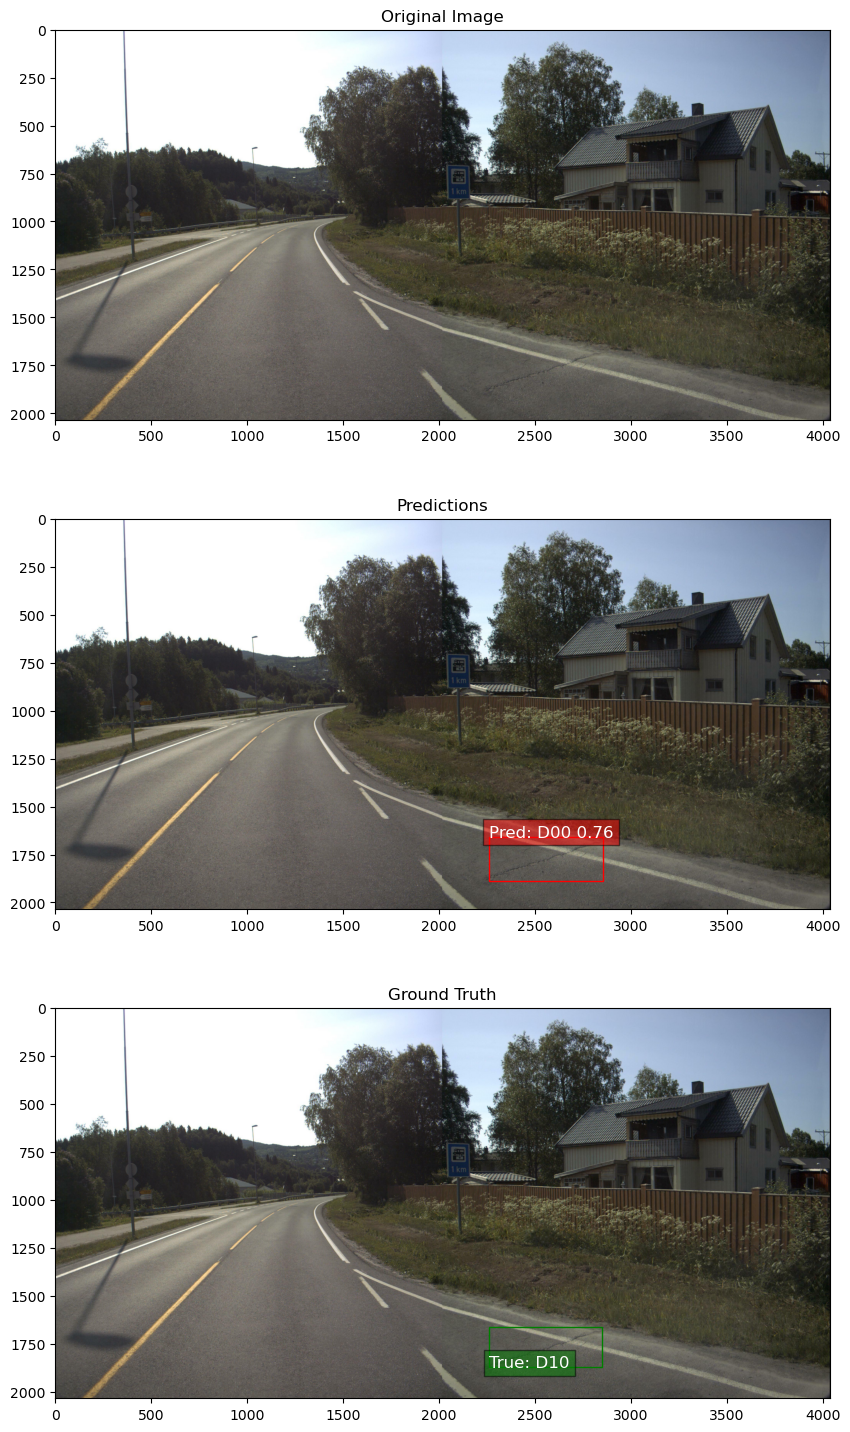

In [11]:
def visualize_comparison_three_plots(image_path, label_path, model, device, dataset_classes, transform=None):
    # Load and prepare image
    image = Image.open(image_path).convert("RGB")
    if transform:
        image_tensor, _ = transform(image, {})  # Assuming the transform function returns a tensor and a target
    else:
        image_tensor = F.to_tensor(image)  # Convert to tensor without any additional transformation

    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and transfer to device

    # Load true labels and boxes
    tree = ET.parse(label_path)
    root = tree.getroot()
    true_boxes = []
    true_labels = []
    for obj in root.iter('object'):
        cls = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(float(xmlbox.find('xmin').text))
        ymin = int(float(xmlbox.find('ymin').text))
        xmax = int(float(xmlbox.find('xmax').text))
        ymax = int(float(xmlbox.find('ymax').text))
        true_boxes.append([xmin, ymin, xmax, ymax])
        true_labels.append(dataset_classes.index(cls))

    # Model inference
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)
    predictions = apply_nms(predictions[0], 30)  # Assuming apply_nms is defined correctly

    # Prepare image for plotting
    image_np = np.array(image)

    # Set up three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))
    ax1.imshow(image_np)
    ax2.imshow(image_np)
    ax3.imshow(image_np)

    # Draw predicted boxes and labels on the second subplot
    pred_boxes = predictions['boxes'].cpu().numpy()
    pred_scores = predictions['scores'].cpu().numpy()
    pred_labels = predictions['labels'].cpu().numpy()

    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
        ax2.text(x1, y1, f'Pred: {dataset_classes[label]} {score:.2f}', color='white', fontsize=12,
                 bbox=dict(facecolor='red', alpha=0.5))

    # Draw true boxes and labels on the third subplot
    for box, label in zip(true_boxes, true_labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='g', facecolor='none')
        ax3.add_patch(rect)
        ax3.text(x1, y2, f'True: {dataset_classes[label]}', color='white', fontsize=12,
                 bbox=dict(facecolor='green', alpha=0.5))

    ax1.set_title('Original Image')
    ax2.set_title('Predictions')
    ax3.set_title('Ground Truth')
    plt.show()

# Example usage
image_path = './Data/images/val/Norway_000830.jpg'
label_path = './Data/xmls/val/Norway_000830.xml'
visualize_comparison_three_plots(image_path, label_path, model, device, train_dataset.classes, transform=get_transform())


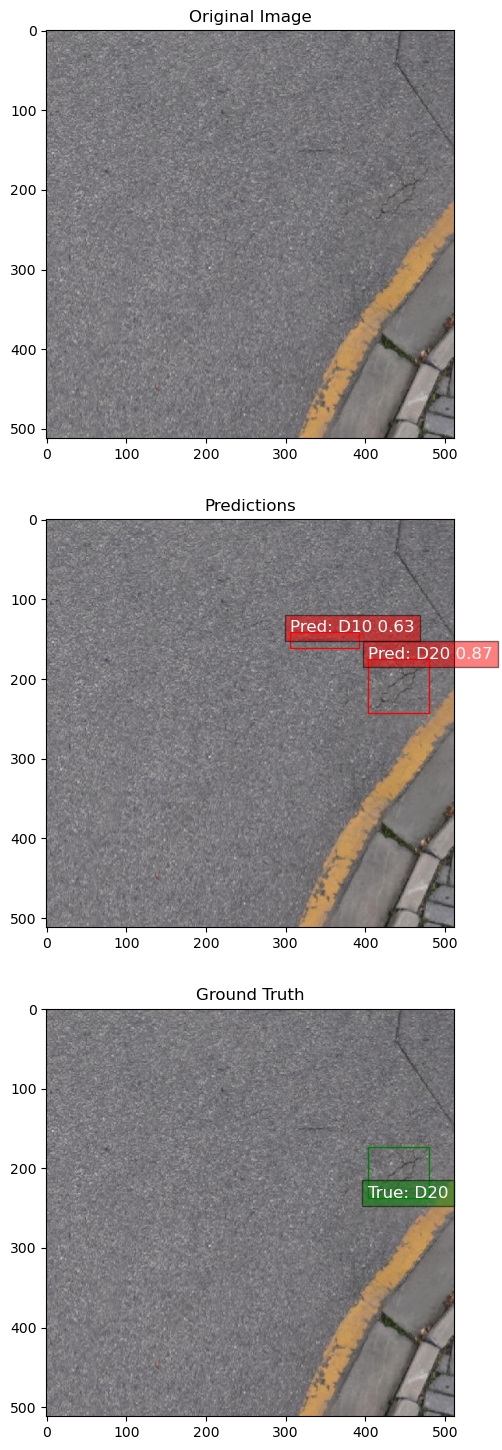

In [12]:
# Example usage
image_path = './Data/images/val/China_Drone_000086.jpg'
label_path = './Data/xmls/val/China_Drone_000086.xml'
visualize_comparison_three_plots(image_path, label_path, model, device, train_dataset.classes, transform=get_transform())


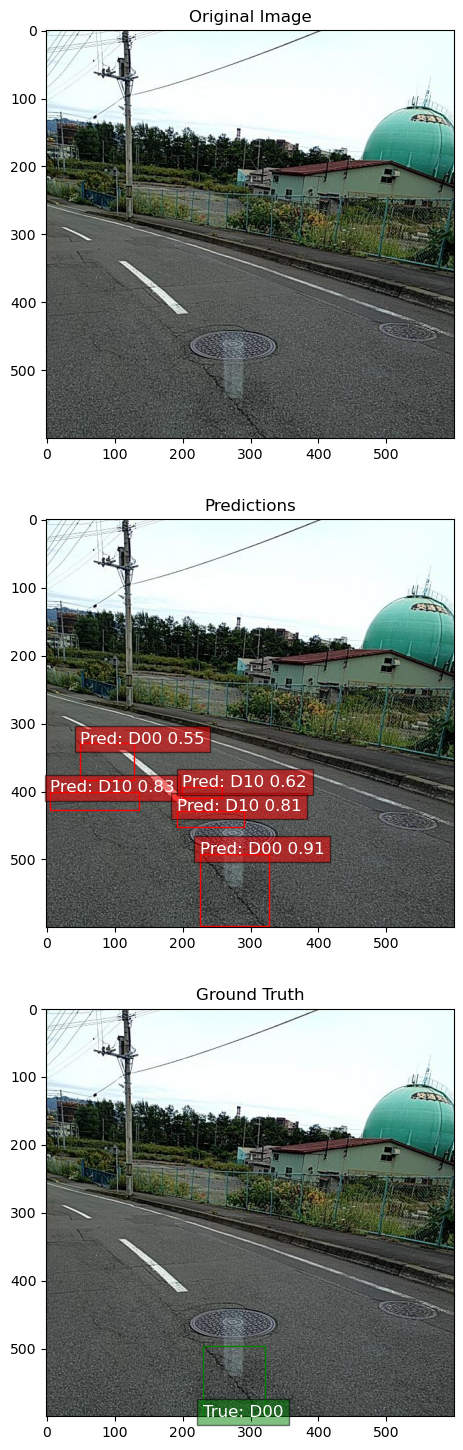

In [13]:
# Example usage
image_path = './Data/images/val/Japan_003127.jpg'
label_path = './Data/xmls/val/Japan_003127.xml'
visualize_comparison_three_plots(image_path, label_path, model, device, train_dataset.classes, transform=get_transform())


In [14]:
import os
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from PIL import Image
local_model_path = f'./faster_rcnn_lr{lr}_bs{train_batch_size}_epochs{num_epochs}_mAP{best_mAP50}.pth'
test_image_dir = os.path.join(image_dir, 'test')
test_label_dir = os.path.join(label_dir, 'test')
model_path = local_model_path
test_batch_size = 4

class TestDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.images = list(sorted(os.listdir(image_dir)))
        self.labels = list(sorted(os.listdir(label_dir)))
        self.class_to_idx = {'Background': 0, 'D00': 1, 'D10': 2, 'D20': 3, 'D40': 4}  # Update as necessary

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.labels[idx])
        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(label_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.iter('object'):
            cls = obj.findtext('name')
            labels.append(self.class_to_idx[cls])
            xmlbox = obj.find('bndbox')
            boxes.append([int(xmlbox.findtext(tag)) for tag in ['xmin', 'ymin', 'xmax', 'ymax']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if boxes.nelement() != 0 else torch.zeros(0, dtype=torch.float32)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx]), 'area': area, 'iscrowd': torch.zeros(len(boxes), dtype=torch.int64)}

        if self.transforms:
            img = self.transforms(img)

        return img, target

def get_transform():
    def transform(img):
        return F.to_tensor(img)
    return transform

# Load the model
def load_model(model_path, num_classes):
    model = get_model(num_classes)  # Ensure get_model is defined or imported
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

test_dataset = TestDataset(test_image_dir, test_label_dir, transforms=get_transform())
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

model = load_model(model_path, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mean_ap, precision, recall, f1_score = evaluate_or_test_model(model, test_loader, device, 1)
print(f'Test mAP50: {mean_ap:.4f}')
print(f'F1 per group: {f1_score}, Recall per group: {recall}, Precision per group: {precision}')
print(f'General F1: {sum(f1_score) / len(f1_score)}, General Recall: {sum(recall) / len(recall)}, General Precision: {sum(precision) / len(precision)}')


Test mAP50: 0.5592
F1 per group: [0.24346532 0.25313049 0.30162868 0.16442932], Recall per group: [0.74763158 0.73175074 0.7284264  0.67407407], Precision per group: [0.14540895 0.15303463 0.19019218 0.09363516]
General F1: 0.24066345053813343, General Recall: 0.7204706972484418, General Precision: 0.14556772902002393
